In [1]:
%matplotlib inline
import math
from itertools import product

import zarr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from distributed import Client
from numcodecs import blosc
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage.exposure import rescale_intensity

In [2]:
client = Client()

In [3]:
codec = blosc.Blosc(cname="zstd", clevel=9, shuffle=blosc.Blosc.SHUFFLE)

In [4]:
image_path = "/root/capsule/data/exaSPIM_706301_training_blocks/block_001/block_001.zarr"
arr = da.from_zarr(image_path, component='0').squeeze()
slice_num = arr.shape[0] // 2
s = arr[slice_num].compute().astype(np.float32)

In [5]:
minimum, maximum = s.min(), s.max()
print(minimum, maximum)

0.0 200.0


In [6]:
def plot_slice(s, title=None):
    plt.figure(figsize=(8,8))
    plt.imshow(s, cmap='gray', vmin=0, vmax=100)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [7]:
sigma_est = estimate_sigma(s, channel_axis=None, average_sigmas=True)
print(sigma_est)

4.829979948389849


In [8]:
sigmas = [sigma_est * i for i in [0.5, 1, 1.5, 2]]
wavelets = ['db2', 'haar', 'sym9']
modes = ['soft']
levels = [None]
methods = ['BayesShrink']


params = list(product(sigmas, wavelets, modes, levels, methods))
#print(params)

Compression ratio: 3.20146062733089


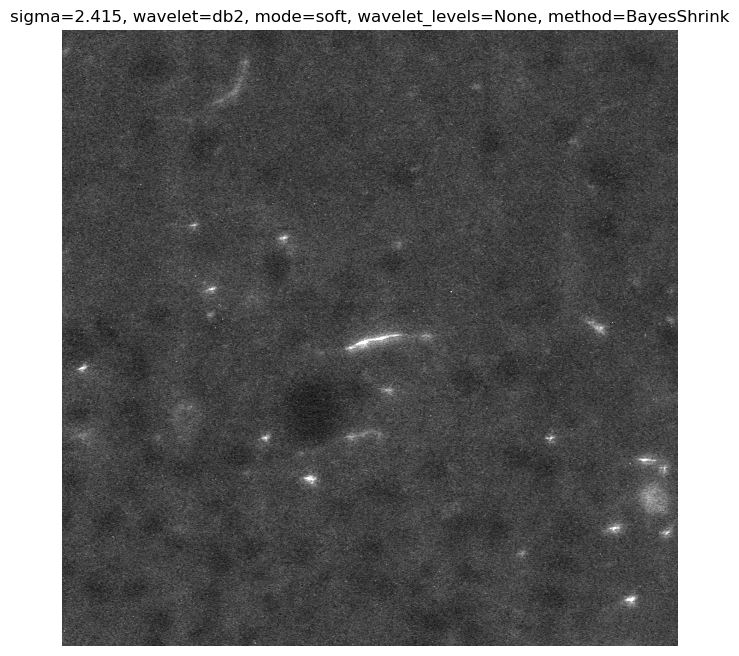

Compression ratio: 3.1394679010053954


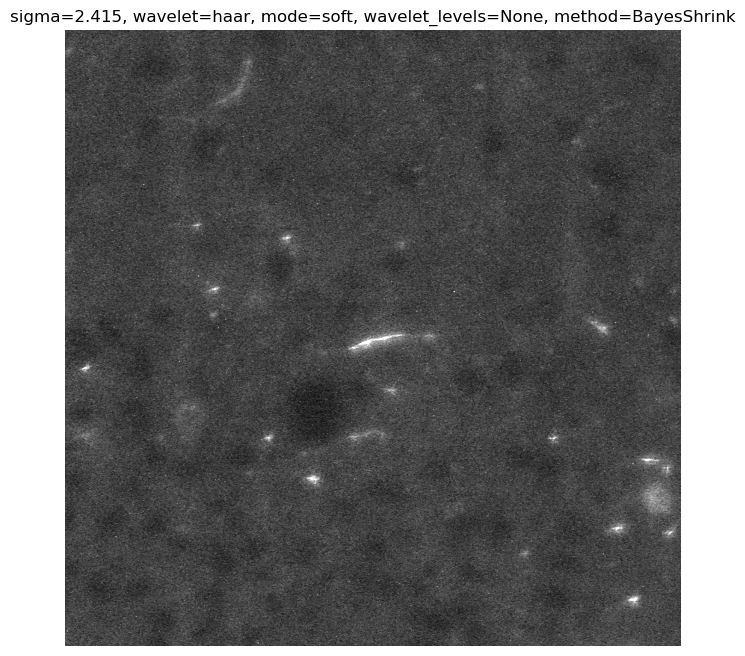

Compression ratio: 3.2120815751384217


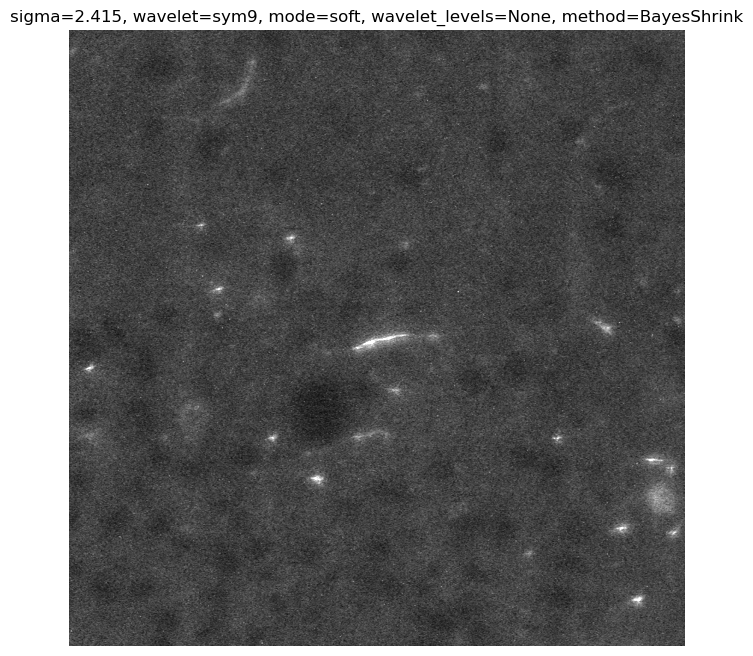

Compression ratio: 4.1146444828127455


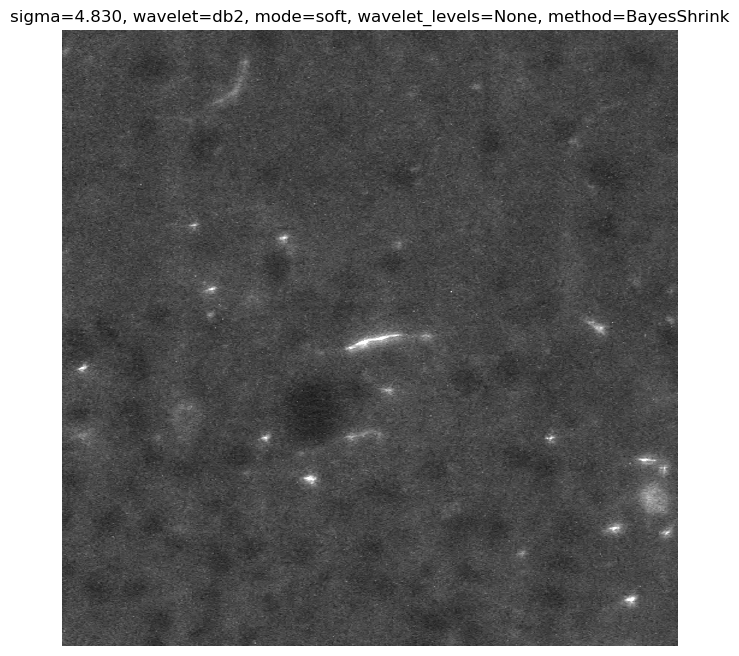

Compression ratio: 5.085595252818457


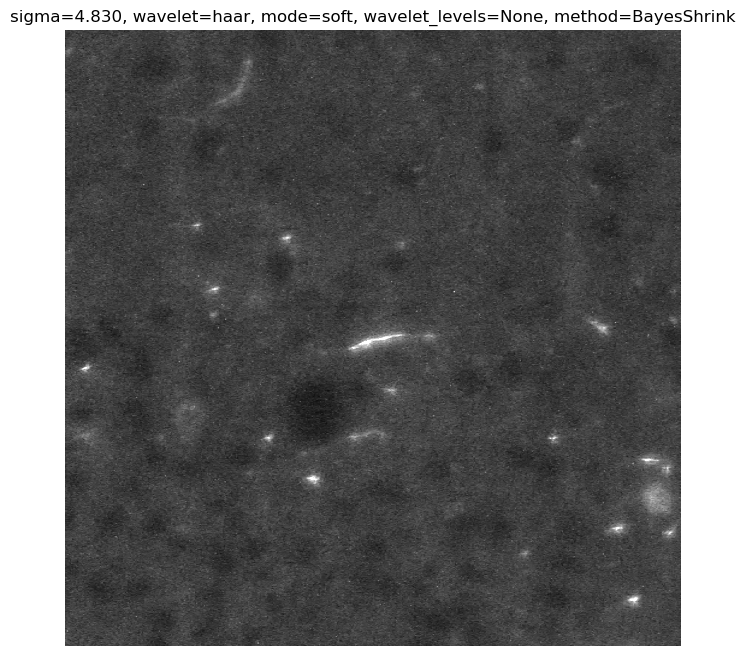

Compression ratio: 3.7837791024956338


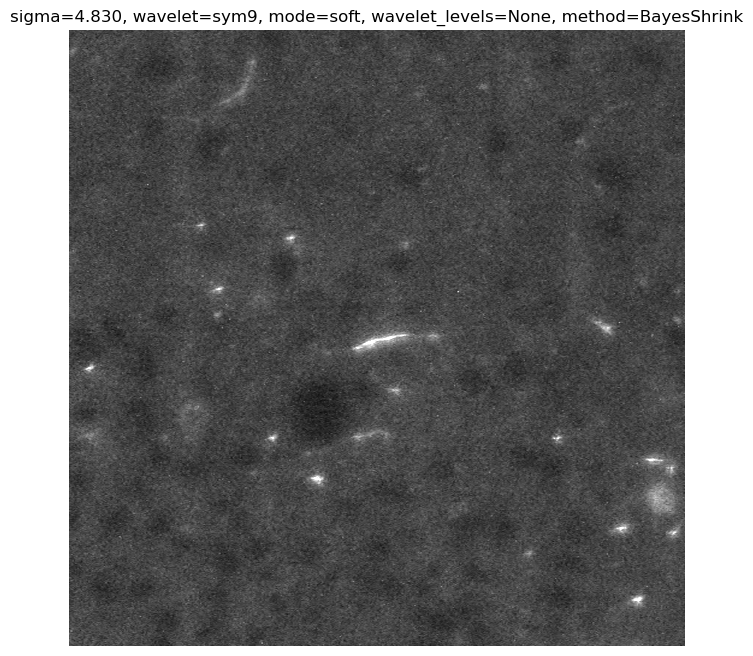

Compression ratio: 5.336726332558033


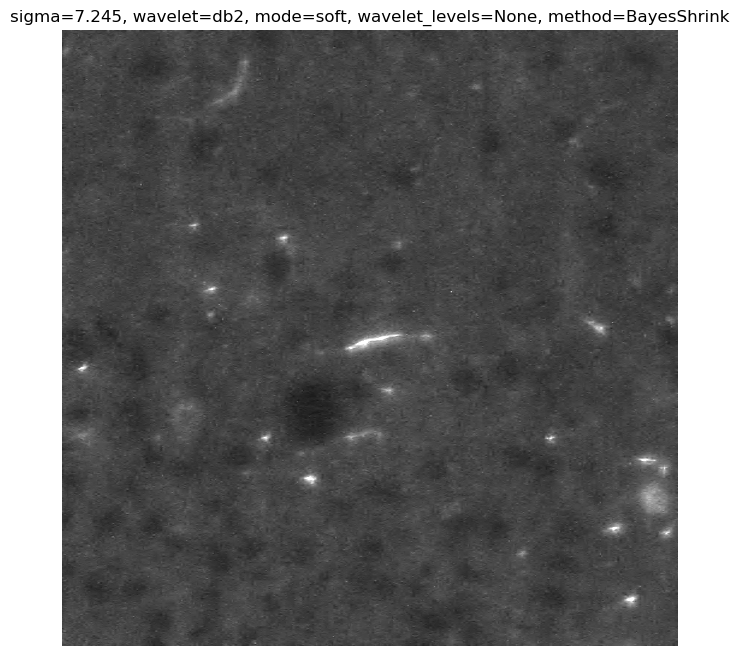

Compression ratio: 9.099141783597567


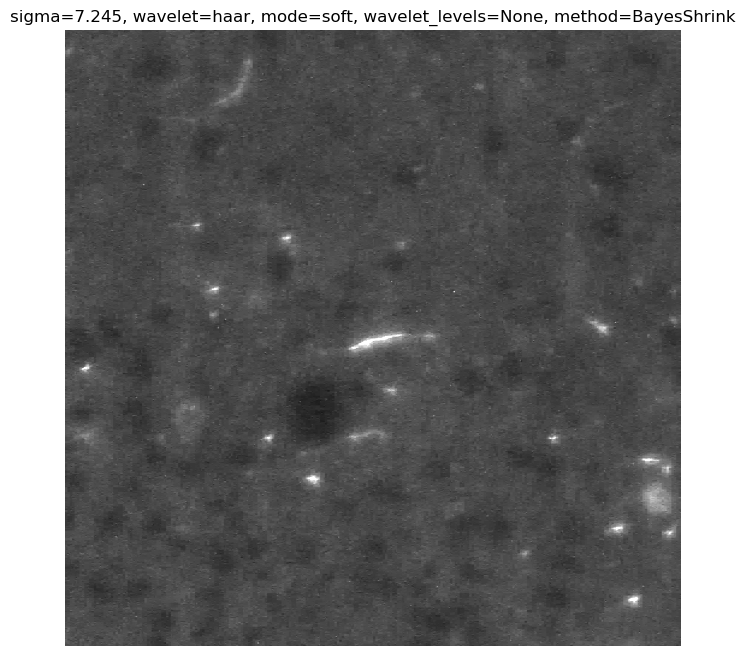

Compression ratio: 4.629096519710311


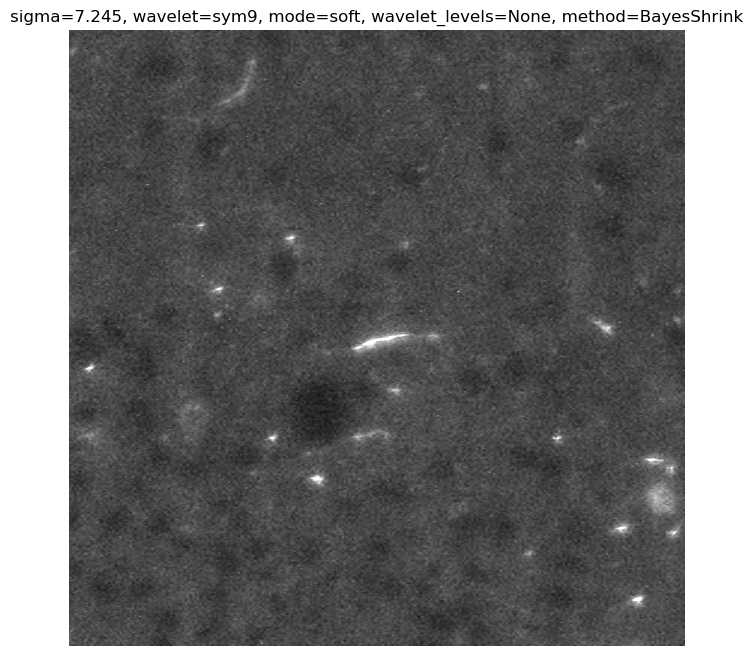

Compression ratio: 11.652268610607964


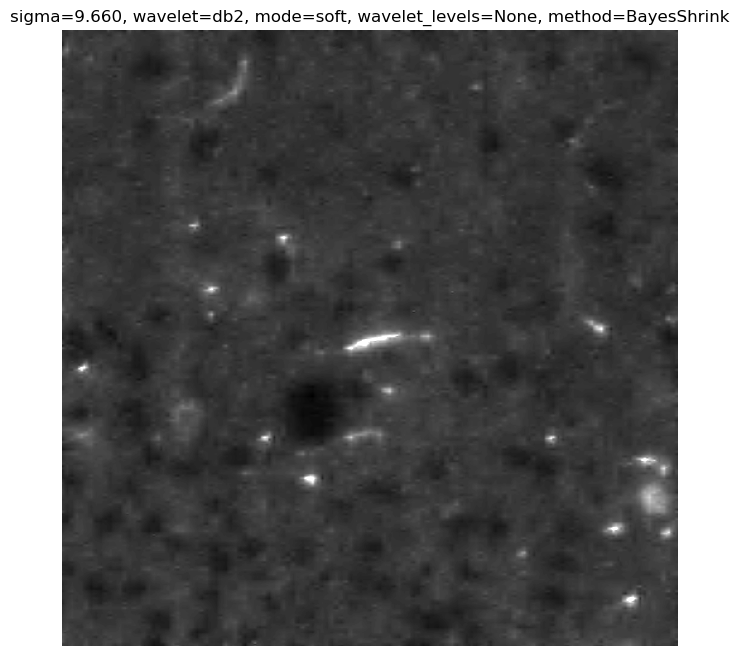

Compression ratio: 122.04096834264432


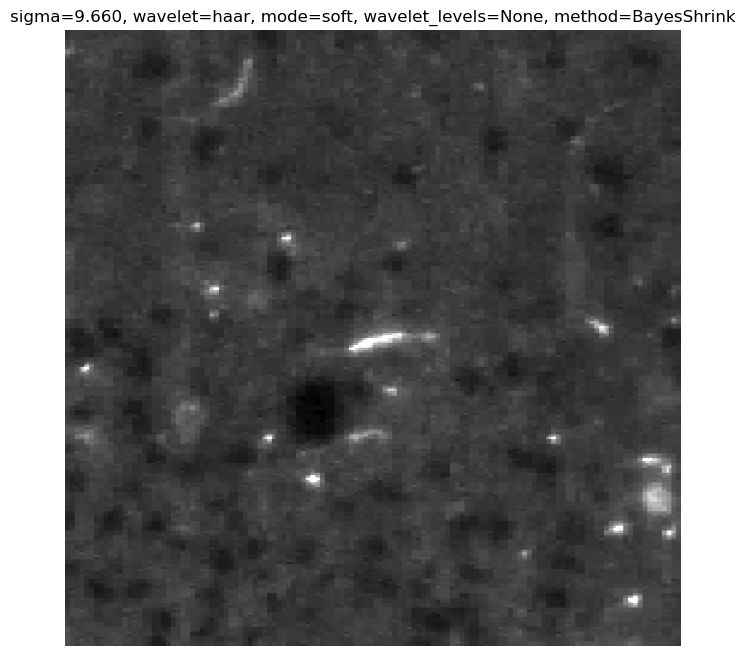

Compression ratio: 6.009186483319054


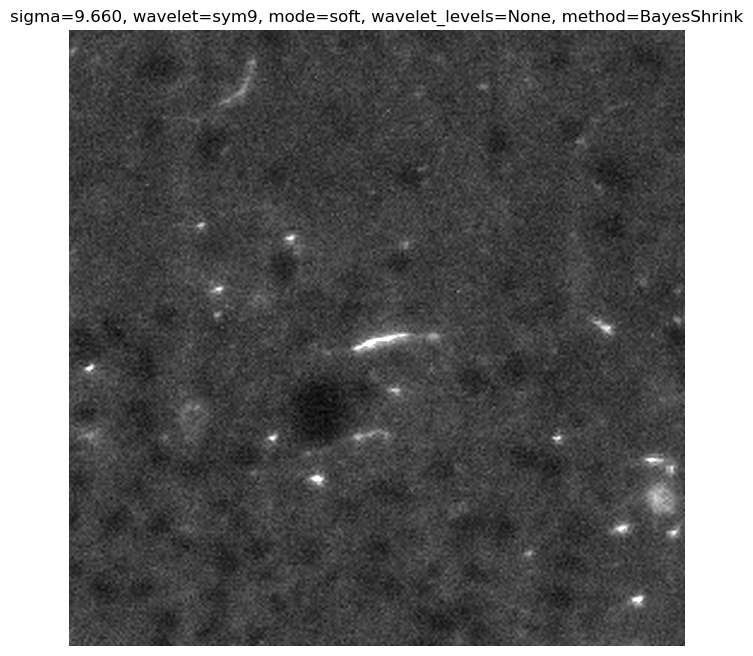

In [9]:
for param_set in params:
    sigma, wavelet, mode, level, method = param_set
    
    result = denoise_wavelet(
        s, 
        sigma=sigma,
        wavelet=wavelet,
        mode=mode, 
        wavelet_levels=level,
        method=method,
        channel_axis=None
    )
    
    result = rescale_intensity(result, in_range='image', out_range=(minimum, maximum)).astype(np.uint16)
    
    encoded_bytes = len(codec.encode(result))
    print(f"Compression ratio: {s.astype(np.uint16).nbytes / encoded_bytes}")
    
    plot_slice(result, title=f"sigma={sigma:.3f}, wavelet={wavelet}, mode={mode}, wavelet_levels={level}, method={method}")